In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as n

In [4]:
from neuron import h
from neuron.units import ms, mV
h.load_file('stdrun.hoc')
nA = 1
A = 1e9

V = 1e3

In [5]:
h.steps_per_ms = 128
h.run()

Changed dt


0.0

In [6]:
def make_IClamp(loc, params):
    stimulus = h.IClamp(loc)
    stimulus.delay = params['stim_delay']
    stimulus.dur = params['stim_dur']
    stimulus.amp = params['stim_amp_nA']
    return stimulus

class Ball:
    def __init__(self,cell_id, params):
        self.cell_id = cell_id
        self.params = params
        self.init_shape() 
        self.init_biophysics()

    def init_shape(self):
        self.soma = h.Section(name='soma', cell=self)
        self.soma.L = self.params['soma_L']
        self.soma.diam = self.params['soma_diam']
#         self.all = [self.soma]
        if self.params.get('dend', 0) > 0:
            self.dends = []
            assert len(self.params['dend_conns']) == self.params['dend']
            for i in range(self.params['dend']):
                self.dends.append(h.Section(name='dend_{}'.format(i)))
                self.dends[i].L = self.params['dend_L']
                self.dends[i].diam = self.params['dend_diam']
                self.dends[i].nseg = self.params['dend_nseg']
                if self.params['dend_conns'][i] == 's':
                    self.dends[i].connect(self.soma)
                else:
                    self.dends[i].connect(self.dends[self.params['dend_conns'][i]])
#                 self.all.append(self.dends[i])
        self.all = self.soma.wholetree()
    
    def init_biophysics(self ):
        
        for sec in self.all:
            sec.Ra = self.params['all_Ra'] # Axial resistance in Ohm * cm      
            sec.cm = self.params['all_cm'] # Membrane capacitance in micro Farads / cm^2
        
        
        self.soma.insert('pas')
        for seg in self.soma:
            seg.pas.g = self.params['soma_g']
            seg.pas.e = self.params['soma_e']
            pass
        
        if self.params.get('soma_hh', False):
            self.soma.insert('hh')                                                    # <-- NEW           
            for seg in self.soma:                                                     # <-- NEW
                seg.hh.gnabar = self.params['soma_hh_gnabar']  # Sodium conductance in S/cm2                   # <-- NEW
                seg.hh.gkbar = self.params['soma_hh_gkbar']  # Potassium conductance in S/cm2                # <-- NEW
                seg.hh.gl = self.params.get('soma_hh_gl', 0.0003)    # Leak conductance in S/cm2                     # <-- NEW
                seg.hh.el = self.params.get('soma_hh_el', -54.3)     # Reversal potential in mV                      # <-- NEW
    
    def __repr__(self):
        return 'Ball_{}'.format(self.cell_id)

In [7]:
def analyze_stim(data, stim, verbose = True):
    stim_start = int(h.steps_per_ms * stim.delay)
    stim_end = int(h.steps_per_ms * (stim.delay + stim.dur))
    stim_waveform = data[stim_start:stim_end]
    
    tau_m = calculate_tau(stim_waveform)
    r_i = calculate_ri(stim_waveform, stim.amp)
    
    if verbose: print("tau_m: {:.2f} secs\nr_i: {:.2f} Gohms".format(tau_m, r_i))
    
    return {'tau_m' : tau_m, 'r_i' : r_i}

def calculate_tau(stim_waveform):
    rising = (stim_waveform[-1] > stim_waveform[0])
    hi = stim_waveform.max()
    lo = stim_waveform.min()
    rng = hi - lo
    if rising: point = n.where(stim_waveform > (lo + rng*0.63))[0][0]
    else: point = n.where(stim_waveform < (lo + rng*0.37))[0][0]
    tau = point * h.dt
    return tau

def calculate_ri(stim_waveform, amplitude_nA):
    hi = stim_waveform.max()
    lo = stim_waveform.min()
    rng = hi - lo
    
    # range (rng) is in mV
    # amplitude is in nA
    # r_i is in Gohms
    r_i = rng / (amplitude_nA)
    return r_i

In [8]:
# params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
#           'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
#           'soma_hh': True,
#           'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0.036}
# hh_cell = Ball(0,params)

# stimulus_params = {'stim_delay' : 20, 'stim_dur' : 1, 'stim_amp_nA' : 0.01, 
#                    'stim_loc' : ('soma', 0, 0.5), 'stim_disable' : False}

# ball = Ball(0, params)
# stimulus = make_IClamp(ball.soma(0.5), stimulus_params)
# v_recording = h.Vector().record(ball.soma(0.5)._ref_v)
# t_recording =  h.Vector().record(h._ref_t)
# gnabar_recording = h.Vector().record(ball.soma(0.5).hh._ref_gna)
# gkbar_recording = h.Vector().record(ball.soma(0.5).hh._ref_gk)                 

# h.finitialize()
# h.continuerun(100 * ms)

# plt.plot(t_recording, v_recording)

# plt.plot(t_recording, gnabar_recording)
# plt.plot(t_recording, gkbar_recording)

In [35]:
def param_sweep(params, stimulus_params, param_sweeps, run_dur_ms = 20):
    
    results = {}

    for parameter in param_sweeps.keys():
        
        params_n = params.copy()
        stimulus_params_n = stimulus_params.copy()  
        
        if parameter in params_n.keys():
            param_dict_to_change = params_n
        elif parameter in stimulus_params_n.keys():
            param_dict_to_change = stimulus_params_n
        param_values = param_sweeps[parameter]
        results[parameter] = {'param_val' : [],
                              'tau_m' : [],
                              'r_i' : [],
                              'gNa' : [],
                              'gKv' : []}
        results[parameter + '_raw'] = []
        i = 0
        for param_val in param_values:
            stimulus_params_n[parameter] = param_val
    #         print(params_n)
            ball = Ball(0,params_n)
            
            if not stimulus_params_n['stim_disable']:
                stim_1Dcoord = stimulus_params_n['stim_loc'][2]
                if stimulus_params_n['stim_loc'][0] == 'soma':
                    stimulus = make_IClamp(ball.soma(stim_1Dcoord), stimulus_params_n)
                elif stimulus_params['stim_loc'][0] == 'dend':
                    dend_id = stimulus_params_n['stim_loc'][1]
                    stimulus = make_IClamp(ball.dends[dend_id](stim_1Dcoord), stimulus_params_n)
            else: 
                print("Stimulus disabled")
            
            recordings = []
            other_recordings = {}
            
            for sec in ball.all:
                recordings.append(h.Vector().record(sec(0.5)._ref_v))
                
            vec1 = h.Vector()
            vec2 = h.Vector()
            if params['soma_hh']:
                other_recordings['gk'] = (vec1.record(ball.soma(0.5).hh._ref_gk))
                other_recordings['gna'] = (vec2.record(ball.soma(0.5).hh._ref_gna))
#                 other_recordings['n_hh'] = (vec2.record(ball.soma(0.5).na_ion.ina))
#                 other_recordings['h_hh'] = (h.Vector().record(ball.soma(0.5).h_hh))
            
            t = h.Vector().record(h._ref_t)

            h.finitialize(params_n['soma_e'] * mV)
            h.continuerun(run_dur_ms * ms)

            vs = n.array(recordings[0])
            ts = n.array(t)

            if not stimulus_params_n['stim_disable']:
                res = analyze_stim(vs, stimulus, verbose = False)
            else:
                res = {'tau_m' : -1, 'r_i' : -1}
                
            tau_m = res['tau_m']
            r_i = res['r_i']
            results[parameter]['param_val'].append(param_val)
            results[parameter]['tau_m'].append(tau_m)
            results[parameter]['r_i'].append(r_i)
            
            
            raw_dict = {'t' : ts}
            j = 0
            for sec in ball.all:
                raw_dict[sec.name()] = n.array(recordings[j])
                j += 1
            if params['soma_hh']:
                for key in ['gk', 'gna']:
                    raw_dict[key] = n.array(other_recordings[key])
                
            results[parameter + '_raw'].append(raw_dict)

            i += 1
    return results

def plot_sweep(results, param, plotfunc = None):
    
    
    
    title = "Sweeping param: {}".format(param)
    res = results[param]
    f, ax1 = plt.subplots()
    
    ax1.set_ylabel("tau_m (sec)")
    ax1.set_xlabel("{}".format(param))
    if plotfunc is None:
        ax1.plot(res['param_val'], res['tau_m'], label='tau_m', color='blue')
    elif plotfunc == 'semilogx':
        ax1.semilogx(res['param_val'], res['tau_m'], label='tau_m', color='blue')
        
    ax2 = ax1.twinx()
    ax2.set_ylabel("r_i (Gohms)")
    if plotfunc is None:
        ax2.plot(res['param_val'], res['r_i'], label='r_i', color='red')
    elif plotfunc == 'semilogx':
        ax2.semilogx(res['param_val'], res['r_i'], label='r_i', color='red')
    
    ax1.legend()
    ax2.legend()
    return f
    
def plot_multiple_recordings(result_dict, title=None, plot_which = 'all'):
    time = result_dict['t']
    for key in result_dict.keys():
        if key == 't': continue
        if plot_which != 'all':
            if key not in plot_which: continue
        plt.plot(time, result_dict[key], label = key)
    plt.legend()
def plot_sweep_waveforms(param_sweeps, results, plot_conductances = False, plot_v = True):
    figs = []
    for key in param_sweeps:
        for i in range(len(param_sweeps[key])):
            f, ax1 = plt.subplots()
            if plot_v:
                ax1.plot(results[key+'_raw'][i]['t'],results[key+'_raw'][i]['Ball_0.soma'], label='voltage', color='black')
                ax1.legend()
            if plot_conductances:
                ax2 = ax1.twinx() if plot_v else ax1
                ax2.plot(results[key+'_raw'][i]['t'],results[key+'_raw'][i]['gna'], label = 'g_Na', color='red')
                ax2.plot(results[key+'_raw'][i]['t'],results[key+'_raw'][i]['gk'], label = 'g_K', color='blue')
                ax2.legend(loc = 'lower right')
            
            
            
            plt.title("Sweeping {}. Value: {:.4f}".format(key, param_sweeps[key][i]))
            plt.show()
            figs.append(f)

### 1. Add HH Na and K voltage-gate channel to the ball model and inject current steps

#### No HH

In [21]:
params = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
          'soma_hh': False,
          'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0}
stimulus_params = {'stim_delay' : 20, 'stim_dur' : 1, 'stim_amp_nA' : 0.01, 
                   'stim_loc' : ('soma', 0, 0.5), 'stim_disable' : False}
param_sweeps = {'stim_amp_nA' : [0.1, 0.5]}

results = param_sweep(params, stimulus_params, param_sweeps, run_dur_ms = 53)

#plot_sweep_waveforms(param_sweeps, results)

#### Na only

In [22]:
params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
          'soma_hh': True,
          'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0}
hh_cell = Ball(0,params)

stimulus_params = {'stim_delay' : 20, 'stim_dur' : 1, 'stim_amp_nA' : 0.01, 
                   'stim_loc' : ('soma', 0, 0.5), 'stim_disable' : False}

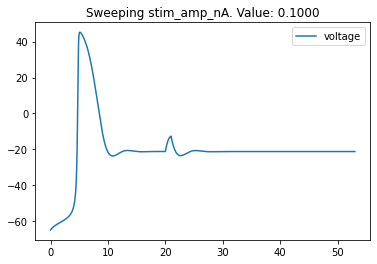

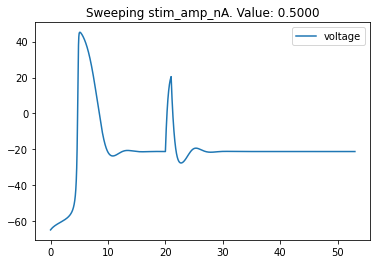

In [24]:
results = param_sweep(params, stimulus_params, param_sweeps, run_dur_ms = 53)

plot_sweep_waveforms(param_sweeps, results, False)

#### K Only

In [25]:
params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
          'soma_hh': True,
          'soma_hh_gnabar' : 0, 'soma_hh_gkbar' : 0.036}
hh_cell = Ball(0,params)

stimulus_params = {'stim_delay' : 20, 'stim_dur' : 1, 'stim_amp_nA' : 0.01, 
                   'stim_loc' : ('soma', 0, 0.5), 'stim_disable' : False}

In [26]:
param_sweeps = {'stim_amp_nA' : [0.001, 0.005, 0.01,0.05,0.1, 0.5]}

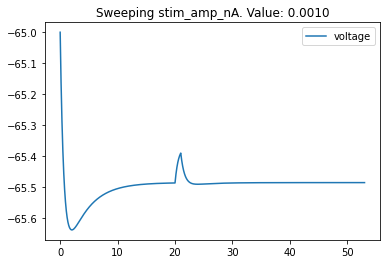

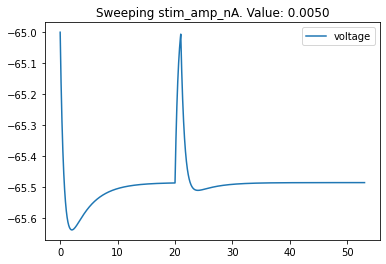

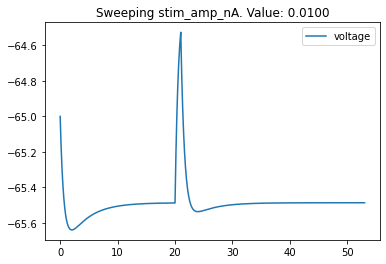

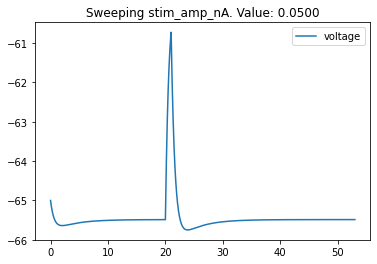

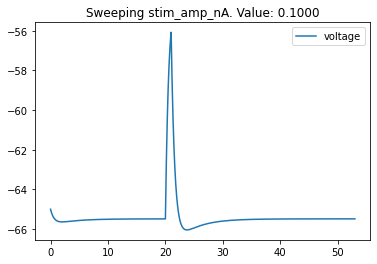

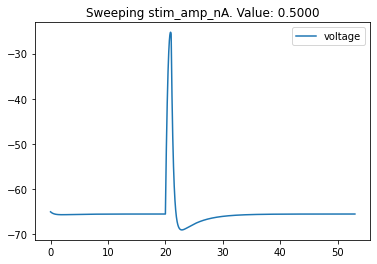

In [27]:
results = param_sweep(params, stimulus_params, param_sweeps, run_dur_ms = 53)

plot_sweep_waveforms(param_sweeps, results)

#### Na and K together

In [28]:
params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
          'soma_hh': True,
          'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0.036}
hh_cell = Ball(0,params)

stimulus_params = {'stim_delay' : 20, 'stim_dur' : 1, 'stim_amp_nA' : 0.01, 
                   'stim_loc' : ('soma', 0, 0.5), 'stim_disable' : False}

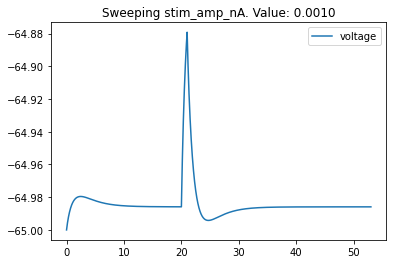

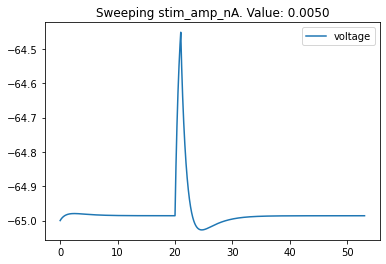

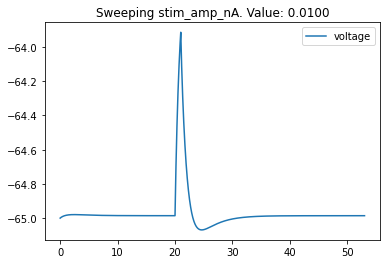

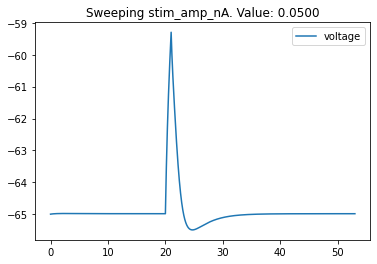

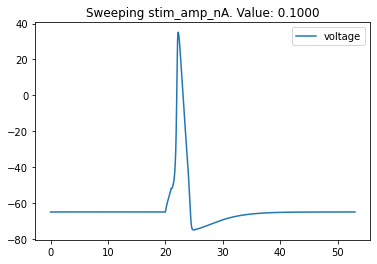

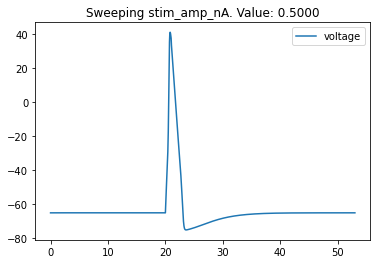

In [29]:
results = param_sweep(params, stimulus_params, param_sweeps, run_dur_ms = 53)

plot_sweep_waveforms(param_sweeps, results)

### Measure gNa and gKv as a function of current injection at the soma

In [36]:
params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
          'soma_hh': True,
          'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0.036,
          'soma_hh_gl' : 0.0003, 'soma_hh_el' : -54.3}
hh_cell = Ball(0,params)

stimulus_params = {'stim_delay' : 20, 'stim_dur' : 1, 'stim_amp_nA' : 0.01, 
                   'stim_loc' : ('soma', 0, 0.5), 'stim_disable' : False}

In [41]:
param_sweeps = {'stim_amp_nA' : n.linspace(0.01, 0.1, 10)}

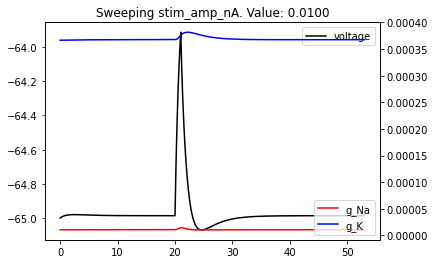

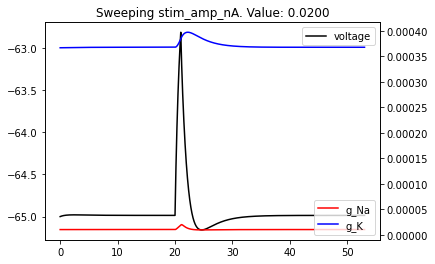

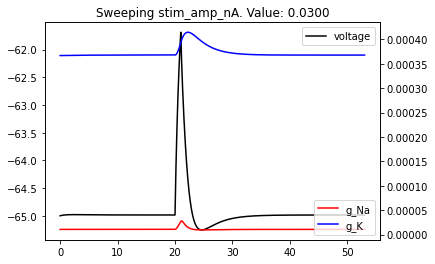

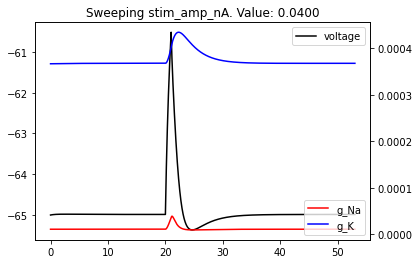

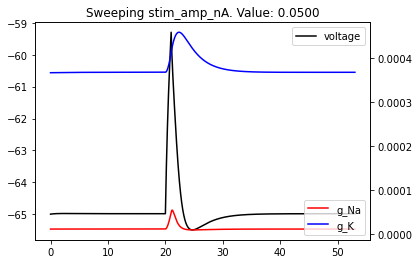

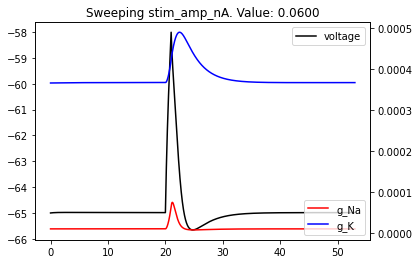

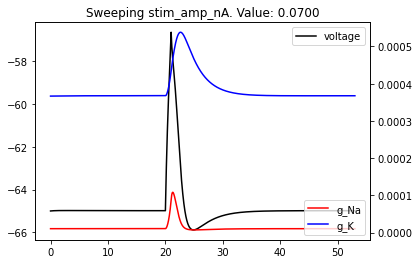

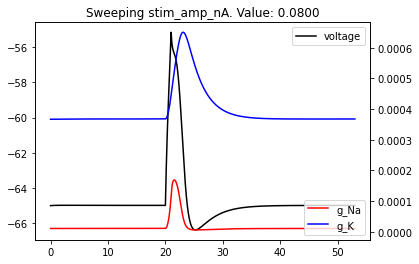

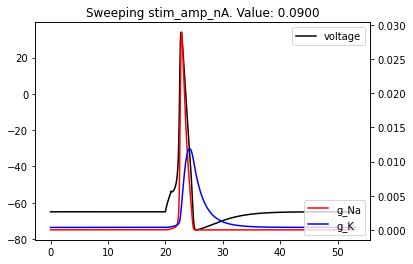

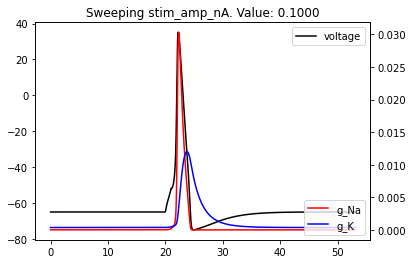

In [42]:
results = param_sweep(params, stimulus_params, param_sweeps, run_dur_ms = 53)

plot_sweep_waveforms(param_sweeps, results, True, True)

In [35]:
hh_cell.soma

Ball_0.soma

In [34]:
hh_cell.soma.n_hh

0.3178944712279015

In [36]:
hh_cell.soma.h_hh

0.5956228870830566

In [13]:
print(', '.join(item for item in dir(hh_cell.soma(0.5)) if not item.startswith('__')))

area, cm, diam, hh, k_ion, na_ion, node_index, pas, point_processes, ri, sec, v, volume, x


In [17]:
hh_cell.soma(0.5).k_ion.ik

0.0